In [ ]:
%pip install --upgrade pip FLAML "flaml[spark]" setuptools wheel optuna optuna-integration openml xgboost catboost imbalanced-learn
# %pip install --upgrade "scikit-learn==1.1.2"
# %pip list

In [1]:
# To allow own package to be imported
import sys
import os
if os.path.dirname(os.getcwd()) not in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from warnings import filterwarnings
filterwarnings(action = "ignore")

# import necessary packages
import pandas as pd
import numpy as np
import polars as pl
import plotly.express as px
import wh0102 as mphd

# Prepare the data dictionary
data_dictionary = {
    "Ethnic":{0:"Malay", 1:"Chinese", 2:"Indian"},
    "bmi":{0:"Normal BMI", 1:"Overweight"},
    "Disease":{0:"No liver disease", 1:"Have Liver Disease"},
    "Gender":{0:"Female", 1:"Male"}
}

# Rename for easier references
column_to_be_rename = {"Sgot":"ALT",
                       "Sgpt":"AST",
                       "Alkphos":"ALP"}

# Prepare the variables
dependent_variable = "Disease"
independent_demographic = ("Age", "Gender", "Ethnic", "bmi",)
independent_investigations = ("AGR", "ALB", "TP", "TB", "DB", "ALP", "ALT", "AST",)
independent_continous = (independent_demographic[0],) + independent_investigations
independent_categorical = independent_demographic[1:]
independent_variables = independent_demographic + independent_investigations

# Load the data
df = pd.read_csv(r"assignment4.csv")

# Rename the column name
df = df.rename(columns = column_to_be_rename)

# To reassign the categorical value
for column in [key for key in data_dictionary.keys() if key != "Gender"]:
    df.loc[:,column] = df.loc[:,column] - 1

# Print the information
df.info()

# To delete after this
missing_df = mphd.missing_values.analyse_missing_row(df)
df = mphd.categorical_data.label_encode(df = df, columns = "Gender", convert_numeric=True)
df = mphd.missing_values.mice_imputation(df = df, columns = "AGR")
# df.drop(columns = ["Patient_ID"]).to_csv(r"imputed_assignment_4.csv", index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  553 non-null    int64  
 1   Age         553 non-null    int64  
 2   TB          553 non-null    float64
 3   DB          553 non-null    float64
 4   ALP         553 non-null    int64  
 5   ALT         553 non-null    int64  
 6   AST         553 non-null    int64  
 7   TP          553 non-null    float64
 8   ALB         553 non-null    float64
 9   AGR         553 non-null    object 
 10  Disease     553 non-null    int64  
 11  Ethnic      553 non-null    int64  
 12  Gender      553 non-null    object 
 13  bmi         553 non-null    int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 60.6+ KB
Missing data detected for columns AGR.
Summary of the missing values from the dataframe =
+------------------------------+-------+--------------------+
|                       

In [6]:
X_train, X_test, y_train, y_test = mphd.pre_processing.train_test_split(df = df,
                                                                        independent_variables=independent_variables,
                                                                        dependent_variable = dependent_variable,
                                                                        test_size = 0.2)
# "estimator_list": ['lgbm', 'lgbm_spark', 'xgboost', 'catboost', 'rf'],
    # "task": 'regression',  # task type    
settings = {
    "time_budget": 120,  # total running time in seconds
    "metric": 'roc_auc',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm',],  # list of ML learners; we tune lightgbm in this example
    "task": 'classification',  # task type    
    "log_file_name": None,  # flaml log file
    "seed": 7654321,    # random seed
    "use_spark": True,  # whether to use Spark for distributed training
    "n_concurrent_trials": 2,  # the maximum number of concurrent trials
}

automl = mphd.machine_learning.automl(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 05-26 21:17:37] {1680} INFO - task = classification
[flaml.automl.logger: 05-26 21:17:37] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 05-26 21:17:37] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 05-26 21:17:37] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2024-05-26 21:17:37,482] A new study created in memory with name: optuna


[I 2024-05-26 21:17:37,539] A new study created in memory with name: optuna


[flaml.tune.tune: 05-26 21:17:37] {735} INFO - Number of trials: 1/1000000, 1 RUNNING, 0 TERMINATED
[flaml.tune.tune: 05-26 21:17:37] {755} INFO - Brief result: {'pred_time': 1.1387738314541904e-05, 'wall_clock_time': 0.466646671295166, 'metric_for_logging': {'pred_time': 1.1387738314541904e-05}, 'val_loss': 0.19427978253996234, 'trained_estimator': <flaml.automl.model.LGBMEstimator object at 0x00000269161E09B0>}
[flaml.tune.tune: 05-26 21:17:37] {735} INFO - Number of trials: 2/1000000, 1 RUNNING, 1 TERMINATED
[flaml.tune.tune: 05-26 21:17:38] {755} INFO - Brief result: {'pred_time': 0.0, 'wall_clock_time': 0.7130277156829834, 'metric_for_logging': {'pred_time': 0.0}, 'val_loss': 0.18690741999837718, 'trained_estimator': <flaml.automl.model.LGBMEstimator object at 0x0000026916AA8470>}
[flaml.tune.tune: 05-26 21:17:38] {735} INFO - Number of trials: 3/1000000, 1 RUNNING, 2 TERMINATED
[flaml.tune.tune: 05-26 21:17:38] {755} INFO - Brief result: {'pred_time': 3.3470717343417078e-06, 'wal

Best hyperparmeter config: {'n_estimators': 21, 'num_leaves': 7, 'min_child_samples': 9, 'learning_rate': 0.414969127271611, 'log_max_bin': 10, 'colsample_bytree': 0.7714909665433299, 'reg_alpha': 0.005456783453304973, 'reg_lambda': 0.12084029088844267}
Best r2 on validation data: 0.8493
Training duration of best run: 0.204 s
r2 = -0.017570664629488197
mse = 0.21621621621621623
mae = 0.21621621621621623


LGBMClassifier(colsample_bytree=0.7714909665433299,
               learning_rate=0.414969127271611, max_bin=1023,
               min_child_samples=9, n_estimators=1, n_jobs=-1, num_leaves=7,
               reg_alpha=0.005456783453304973, reg_lambda=0.12084029088844267,
               verbose=-1)

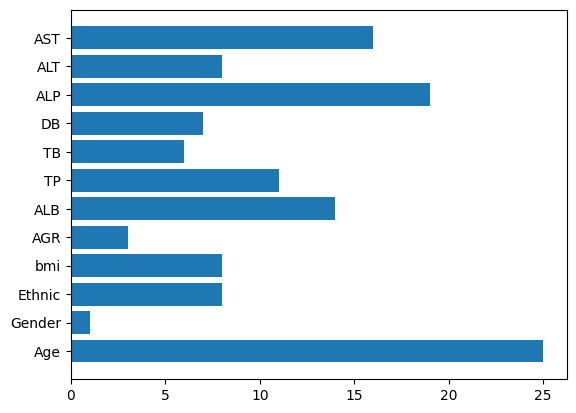

In [7]:
mphd.analyse_ml.analyse_automl(automl=automl, X_test = X_test, y_test = y_test)
automl.model.estimator

In [ ]:
# import optuna.integration.lightgbm as lgb
from optuna.integration import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.metrics import accuracy_score

dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)],
)

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
accuracy = accuracy_score(y_test, prediction)

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

In [ ]:
# Convert the gender
df = mphd.categorical_data.label_encode(df = df, columns = "Gender", convert_numeric=True)
# "Gender":{0:"Female", 1:"Male"}

# Check for duplication
duplicated_df, to_drop_duplicated_df = mphd.pre_processing.check_duplication(df)

# Check for missing value
missing_df = mphd.missing_values.analyse_missing_row(df)
missing_df

## To fix AGR == ' ' issue

In [ ]:
# Calculate the Globulin for every patient ID with globulin = tp - alb based on resource below:
# https://www.ncbi.nlm.nih.gov/books/NBK204/#:~:text=The%20total%20globulin%20fraction%20is,of%20further%20fractionating%20serum%20proteins

# To check the truthness of this on the data
# Create a deep copy of the df with AGR not null first
temp_df = df.query("AGR.notnull()").copy(deep = True)

# Calculatet the globulin and agr_ratio
def calculate_agr(df:pd.DataFrame, column_name:str):
    df.loc[:,column_name] = df.loc[:,"ALB"] / (df.loc[:,"TP"] - df.loc[:,"ALB"])
    return df

# Calculate the approximate agr
temp_df = calculate_agr(df = temp_df, column_name = "agr_new")
# Check for float similarity
temp_df.loc[:,"agr_similarity"] = temp_df.loc[:,("AGR", "agr_new",)].apply(lambda x: np.isclose(float(x[0]), x[1], rtol = 0.1), axis = 1)

# Pivot the information
pt = temp_df.pivot_table(index = "agr_similarity", values = "Patient_ID", aggfunc = len, margins = True).rename(columns={"Patient_ID":"count"})
# Calculate percentage
pt.loc[:,"percentage"] = round(pt.loc[:,"count"] / pt.loc["All", "count"] * 100, 2)

print(pt.to_markdown(tablefmt = "pretty"))

# Check on the not similarity result
temp_df.query("agr_similarity == False")

In [ ]:
# Trial to impute with calculation
missing_df = calculate_agr(df = missing_df, column_name="AGR")
missing_df

In [ ]:
# Impute with MICE
# https://medium.com/@brijesh_soni/topic-9-mice-or-multivariate-imputation-with-chain-equation-f8fd435ca91#:~:text=MICE%20stands%20for%20Multivariate%20Imputation,produce%20a%20final%20imputed%20dataset.

df = mphd.missing_values.mice_imputation(df = df, columns = "AGR")
# Check on the imputated value
df.loc[missing_df.index]

__intepretation__:

For imputation, despite the logic of how AGR being calculated, there is a lot of noise in the data for AGR value, therefore we would use MICE for imputation.

In [ ]:
# Reverse Encode
data = mphd.categorical_data.reverse_encode(df = df, json_dict=data_dictionary)
data

## Continous Data

In [ ]:
# Check for normal distribution
normal_distribution_list, abnormal_distribution_list = mphd.continous_data.descriptive_analysis(df = df, 
                                                                                                independent_variables=independent_continous, 
                                                                                                dependent_variables = dependent_variable,
                                                                                                descriptive_type = "continous",
                                                                                                plot_dependent_variables = False,
                                                                                                plot_correlation = False, 
                                                                                                round = 4)

## Categorical Data

In [ ]:
categorical_summary = mphd.categorical_data.categorical_descriptive_analysis(data,
                                                                             independent_variables = independent_categorical, 
                                                                             dependent_variables = dependent_variable)

## Model Training

In [ ]:
# Logistic Regression
# set acceptable p value
acceptable_p_value = 0.05

# For binominal logistic regression with 2 different depression score outcome along with all independent variable are categorized
logistic_models, summary_logistic_models = mphd.regression.regression_list(df = df, mode = "sm.Logit",
                                                                                   independent_variables = independent_demographic + independent_investigations,
                                                                                   dependent_variables = dependent_variable,
                                                                                   p_value_cut_off = acceptable_p_value)

# To display some information
columns_to_display = ("pseudo_r_2", "log_likelihood", "llr_p_value", "aic_akaike_information_criterion", "bic_bayesin_information_criterion", "coeff_all_significant")
summary_logistic_short = mphd.regression.analyse_model_summary(summary_logistic_models.loc[:,("variables", "num_variables") + columns_to_display + 
                                                                                      ("roc", "shapiro_residual", 
                                                                                       "Lagrange_Multiplier", "Lagrange_Multiplier_p-value",
                                                                                       "F-statistic", "F-statistic_p-value")], 
                                                      top_count = 3,
                                                      parameters= {"aic_akaike_information_criterion": True,
                                                                   "bic_bayesin_information_criterion": True,
                                                                   "pseudo_r_2": False, 
                                                                   "roc":False})
print(summary_logistic_short.round(4).to_markdown(tablefmt = "pretty"))
print(logistic_models[2893].summary())

In [ ]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

num_cols = ['age', 'bmi', 'sys_bp', 'dias_bp', 'hba1c', 'ldl']
cat_cols = ['sex', 'ethnic', 'retinopathy', 'ihd', 'cevd', 'nephropathy']

n_estimators = [100, 300]
max_depth = [3,4,5]
min_child_weight = range(1,3,1)
booster = ['gbdt']
base_score = [0.5,0.6]
learning_rate = [0.1,0.2]
objective = ['binary']
seed = [27]
gamma= [0.7,0.8,0.9]
colsample_bytree=[0.7,0.8,0.9]
subsample=[0.6,0.7,0.8]
reg_alpha = [1e-5,0.01,0.03]
weights = np.linspace(0.3, 0.9, 2)
num_leaves = [6]

lgbm_params = {'classifier__n_estimators': n_estimators, 'classifier__max_depth': max_depth,
               'classifier__learning_rate' : learning_rate, 'classifier__min_child_weight' : min_child_weight, 
               'classifier__boosting_type' : booster, 'classifier__seed':seed,'smote__sampling_strategy': weights,
               'classifier__reg_alpha':reg_alpha, 'classifier__num_leaves':num_leaves}

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,independent_demographic+independent_investigations],
                                                    df.loc[:,dependent_variable],
                                                    test_size=0.2,
                                                    stratify=df.loc[:,dependent_variable],
                                                    random_state=11)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), independent_continous),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([('smote', SMOTE(random_state=11)),
                     ('scaler', preprocessor),
                     ('classifier', LGBMClassifier())])

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = lgbm_params
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

model = grid_search.fit(X_train, y_train, num_boost_round=1000, early_stopping_rounds=50, verbose_eval=100)
model.predict(X_test)